# **1. Import các thư viện cần thiết**

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# **2. Tải tập dữ liệu**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset/fer2013/train/Sad/3180.jpg  
 extracting: dataset/fer2013/train/Sad/3181.jpg  
 extracting: dataset/fer2013/train/Sad/3182.jpg  
 extracting: dataset/fer2013/train/Sad/3183.jpg  
 extracting: dataset/fer2013/train/Sad/3184.jpg  
 extracting: dataset/fer2013/train/Sad/3185.jpg  
 extracting: dataset/fer2013/train/Sad/3186.jpg  
 extracting: dataset/fer2013/train/Sad/3187.jpg  
 extracting: dataset/fer2013/train/Sad/3188.jpg  
 extracting: dataset/fer2013/train/Sad/3189.jpg  
 extracting: dataset/fer2013/train/Sad/319.jpg  
 extracting: dataset/fer2013/train/Sad/3190.jpg  
 extracting: dataset/fer2013/train/Sad/3191.jpg  
 extracting: dataset/fer2013/train/Sad/3192.jpg  
 extracting: dataset/fer2013/train/Sad/3193.jpg  
 extracting: dataset/fer2013/train/Sad/3194.jpg  
 extracting: dataset/fer2013/train/Sad/3195.jpg  
 extracting: dataset/fer2013/train/Sad/3196.jpg  
 extracting: dataset/fer2013/train/Sad/3197.jpg  


In [ ]:
data_dir = '/content/dataset/fer2013'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['validation', 'README', 'fer2013.bib', 'train', 'fer2013.csv']
Train Classes - ['Happy', 'Sad', 'Neutral', 'Angry']
Validation Classes - ['Happy', 'Sad', 'Neutral', 'Angry']


In [ ]:
# Chuẩn hoá các ảnh trong huấn luyện và kiểm tra
# (Chuyển về ảnh xám, lật, xoay ảnh...)

train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [ ]:
# Tải dữ liệu hình ảnh được tổ chức theo thư mục
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

In [ ]:
# Số lượng ảnh trong 1 lô (batch) dữ liệu
batch_size = 200

In [ ]:
# Tải dữ liệu để huấn luyện và kiểm tra
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Hàm in mẫu dữ liệu trong lô
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


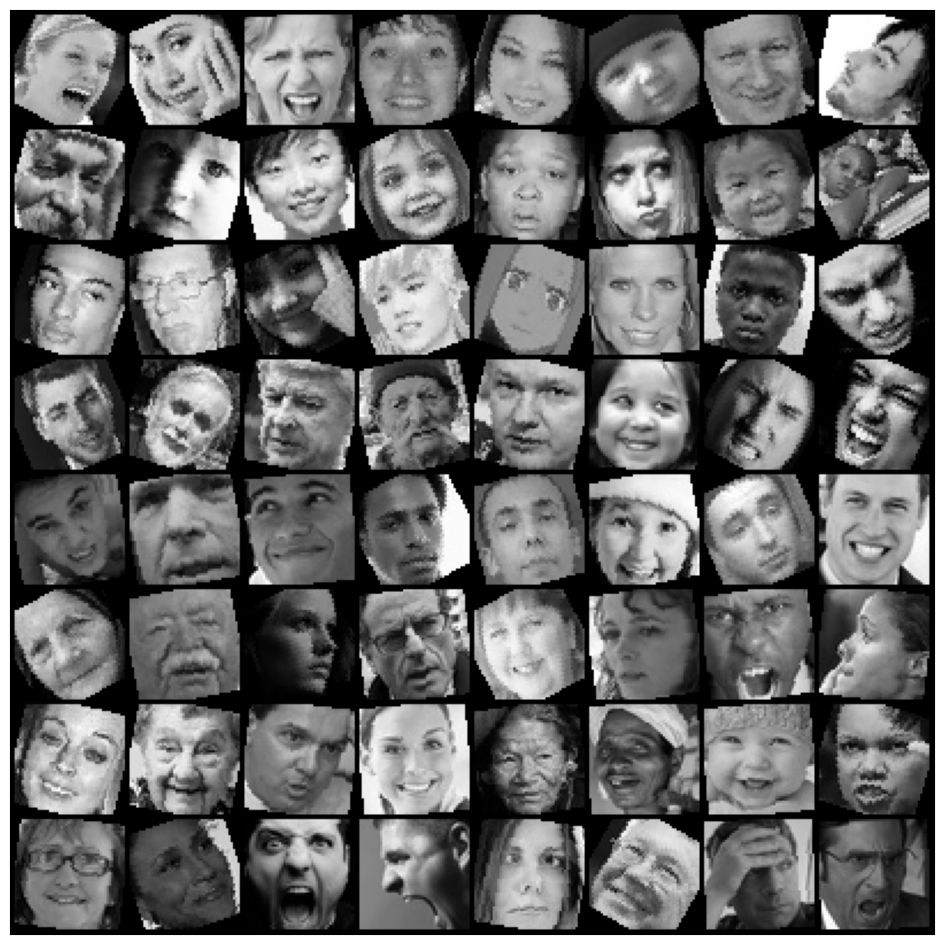

In [ ]:
show_batch(train_dl)

In [ ]:
# Lấy thông tin về môi trường sử dụng
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Hàm tải dữ liệu vào thiết bị
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# **3. Khai báo mô hình và các hàm chức năng**

In [ ]:
# Hàm tính độ chính xác
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Khai báo lớp mô hình cơ sở có các hàm sử dụng trong việc huấn luyện,
# được mở rộng từ nn.Module, dùng để định nghĩa các lớp và mô hình mạng nơ-ron
class ImageClassificationBase(nn.Module):
    # Hàm trả về chỉ số loss trong huấn luyện
    # loss là chỉ số đo độ sai lệch giữa dự đoán của mô hình và giá trị thực tế
    # cross_entropy loss được dùng trong các bài toán phân loại
    def training_step(self, batch):
        images, labels = batch
        out,fmap = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    # Hàm trả về các thông số trong quá trình xác nhận
    def validation_step(self, batch):
        images, labels = batch
        out,fmap = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    # Hàm trả về các thông số khi quá trình xác nhận kết thúc
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# Khai báo khối tích chập
# Nếu pool=True thì khối tích chập trở thành khối dư (Residual Block)
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool:
      layers.append(nn.MaxPool2d(2))

    # Sequential để định nghĩa các lớp là tuần tự, từ trên xuống
    return nn.Sequential(*layers)

# Lớp mô hình ResNet sử dụng để huấn luyện
# conv là khối tích chập
# res là khối dư
class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        feature_maps = {}  # Lưu các feature map tại mỗi lớp

        out = self.conv1(xb)
        feature_maps['conv1'] = out

        out = self.conv2(out)
        feature_maps['conv2'] = out

        out = self.res1(out) + out
        feature_maps['res1'] = out

        out = self.drop1(out)

        out = self.conv3(out)
        feature_maps['conv3'] = out

        out = self.conv4(out)
        feature_maps['conv4'] = out

        out = self.res2(out) + out
        feature_maps['res2'] = out

        out = self.drop2(out)

        out = self.conv5(out)
        feature_maps['conv5'] = out

        out = self.conv6(out)
        feature_maps['conv6'] = out

        out = self.res3(out) + out
        feature_maps['res3'] = out

        out = self.drop3(out)

        out = self.classifier(out)

        return out, feature_maps

In [ ]:
# Khai báo mô hình có số kênh màu đầu vào là 1, số lớp đầu vào là số các class train, thiết bị là device (cpu hoặc cuda)
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
def show_feature_maps(feature_maps, num_features=5):
    for layer_name, fmap in feature_maps.items():
        # Chọn một số lượng feature map nhất định để hiển thị
        fmap = fmap[0, :num_features, :, :].detach().cpu()
        num_maps = fmap.shape[0]

        fig, axs = plt.subplots(1, num_maps, figsize=(15, 5))
        fig.suptitle(f"Feature maps from layer: {layer_name}")

        for i in range(num_maps):
            axs[i].imshow(fmap[i].numpy(), cmap='viridis')
            axs[i].axis('off')

        plt.show()

In [ ]:
# Mở ảnh demo feature map
img_path = '/content/dataset/fer2013/train/Angry/0.jpg'
img = Image.open(img_path)

to_tensor = tt.ToTensor()
img_input = to_device(to_tensor(img), device)

img_input.shape

torch.Size([1, 48, 48])

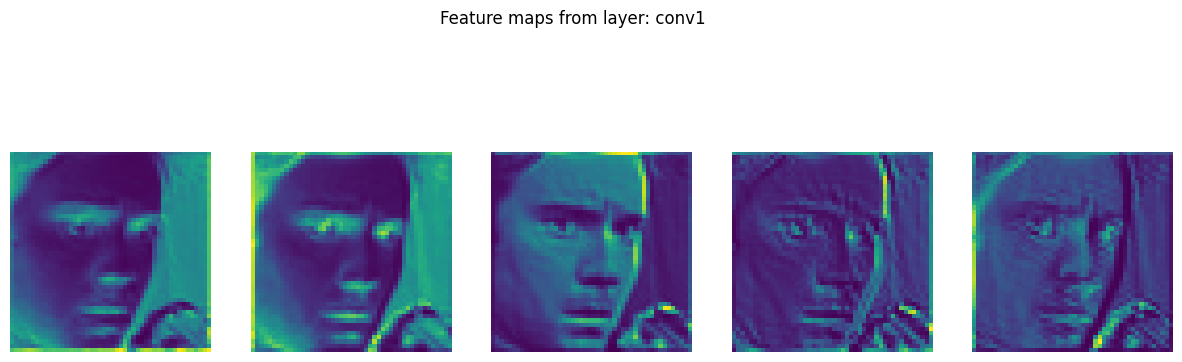

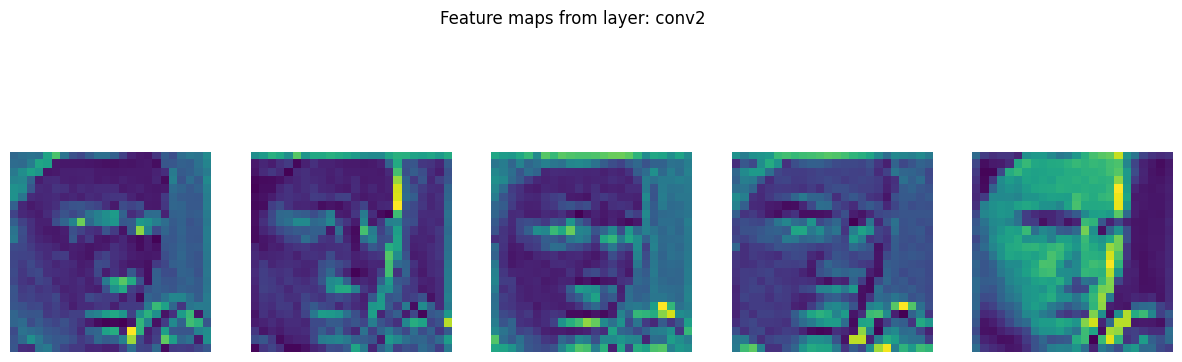

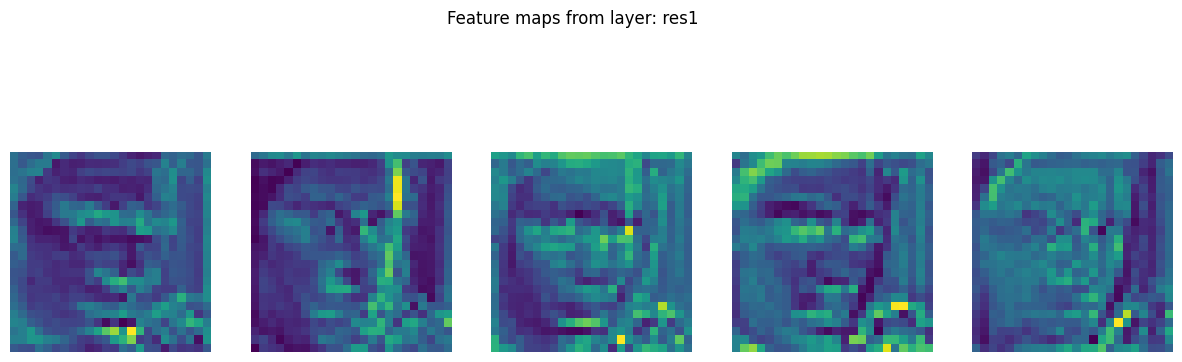

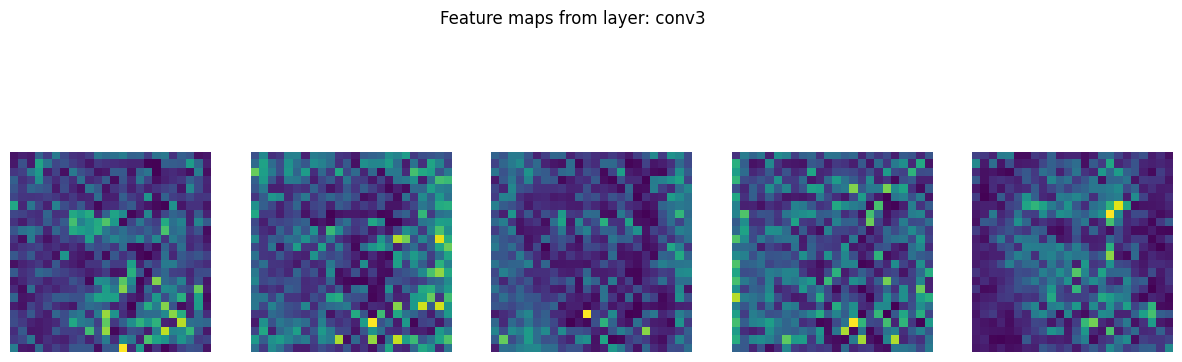

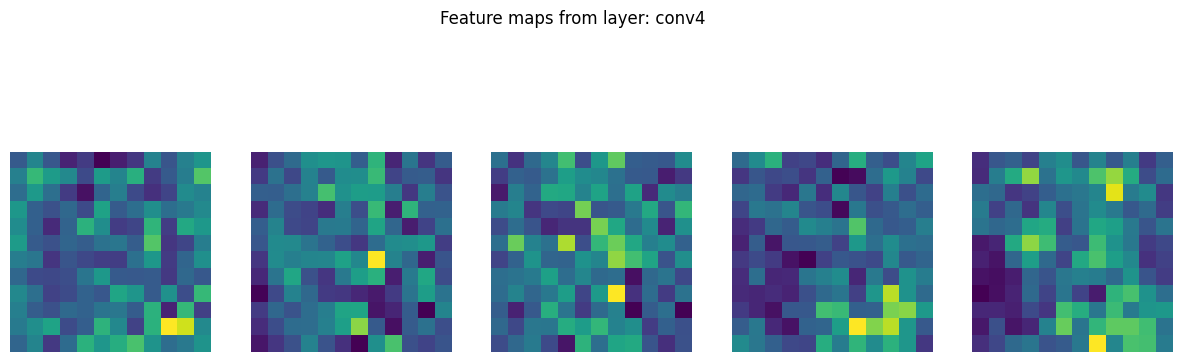

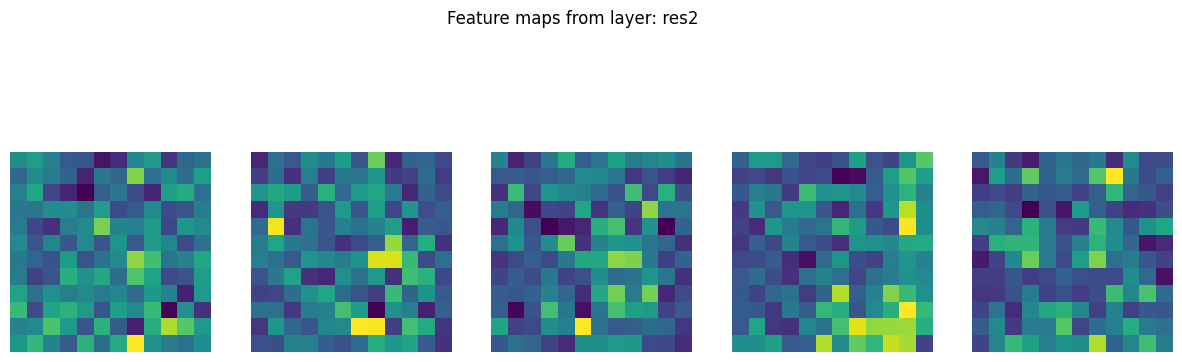

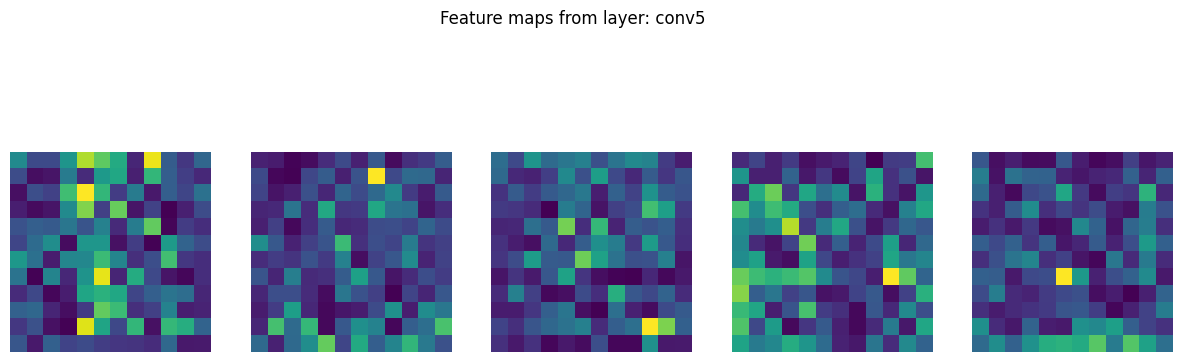

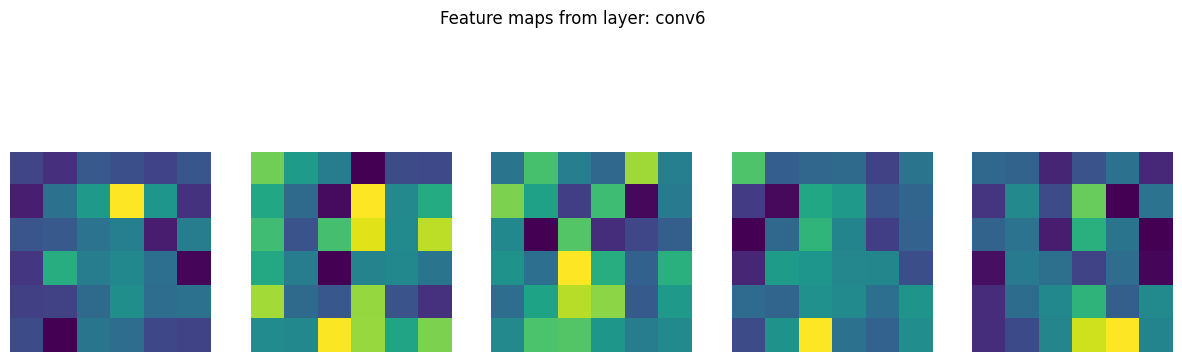

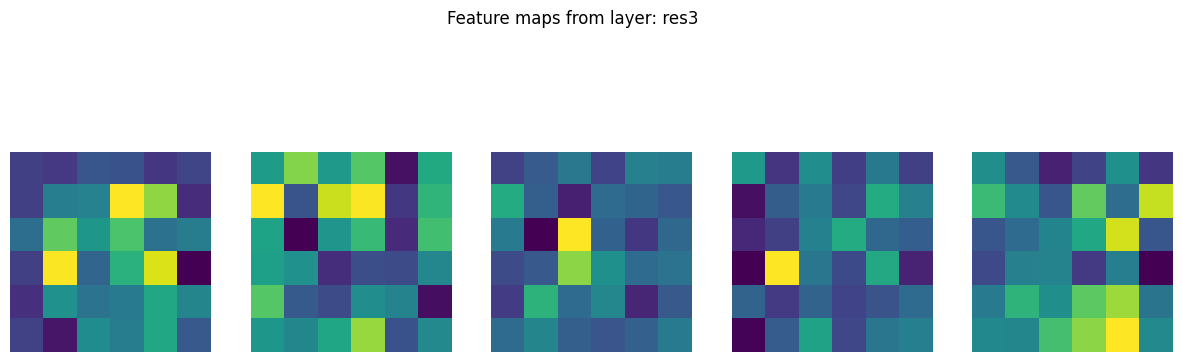

In [ ]:
img_path = '/content/dataset/fer2013/train/Angry/0.jpg'
img = Image.open(img_path)

to_tensor = tt.ToTensor()
img_input = to_device(to_tensor(img).unsqueeze(0), device)

# Lấy output và feature maps từ model
output, feature_maps = model(img_input)

# Hiển thị các feature maps
show_feature_maps(feature_maps)

In [ ]:
# Hàm để lưu kết quả của mô hình, để sử dụng mô hình đã huấn luyện cho mục đích cá nhân
def save_best_checkpoint(model, optimizer, epoch, val_loss, best_val_loss, checkpoint_path):
    checkpoint_path ="best_model.pth"
    # chỉ lưu từ điển trạng thái của mô hình khi val_loss thấp hơn
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch} with best validation loss {val_loss:.4f}")
    return best_val_loss

In [ ]:
# Hàm in đánh giá mô hình
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Hàm trả về tốc độ học của mô hình
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Hàm huấn luyện mô hình, sử dụng kỹ thuật fit_one_cycle để cải thiện quá trình học tập bằng cách điều chỉnh tốc độ học
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Cài đặt hàm tối ưu tuỳ chỉnh với weight decay (suy giảm trọng số)
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # Cài đặt one-cycle để tự động điều chỉnh tốc độ học
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    best_val_loss = float("inf")
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Lưu và cập nhật tốc độ học
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        best_val_loss = save_best_checkpoint(model, optimizer, epoch + 1, result['val_loss'], best_val_loss, "model.keras")
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.3880940675735474, 'val_acc': 0.22357143461704254}]

# **4. Huấn luyện mô hình**

In [ ]:
# khai báo các tham số sử dụng trong quá trình huấn luyện
epochs = 50                 # số lần train trên bộ dữ liệu
max_lr = 0.008              # tốc độ học tối đa khi sử dụng fit_one_cycle
grad_clip = 0.1             # giới hạn độ lớn của gradient
weight_decay = 1e-4         # suy giảm trọng số, ngăn overfitting
opt_func = torch.optim.Adam # hàm tối ưu Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [1], last_lr: 0.00040, train_loss: 1.5893, val_loss: 1.3725, val_acc: 0.3982
Checkpoint saved at epoch 1 with best validation loss 1.3725
Epoch [2], last_lr: 0.00065, train_loss: 1.2757, val_loss: 1.2935, val_acc: 0.4209
Checkpoint saved at epoch 2 with best validation loss 1.2935
Epoch [3], last_lr: 0.00105, train_loss: 1.2307, val_loss: 1.2331, val_acc: 0.4402
Checkpoint saved at epoch 3 with best validation loss 1.2331
Epoch [4], last_lr: 0.00159, train_loss: 1.2261, val_loss: 1.1546, val_acc: 0.5162
Checkpoint saved at epoch 4 with best validation loss 1.1546
Epoch [5], last_lr: 0.00224, train_loss: 1.1594, val_loss: 1.2119, val_acc: 0.4429
Epoch [6], last_lr: 0.00297, train_loss: 1.2740, val_loss: 1.4904, val_acc: 0.3270
Epoch [7], last_lr: 0.00375, train_loss: 1.3002, val_loss: 1.2452, val_acc: 0.4393
Epoch [8], last_lr: 0.00456, train_loss: 1.2829, val_loss: 1.4757, val_acc: 0.4378
Epoch [9], last_lr: 0.00534, train_loss: 1.3940, val_loss: 1.1944, val_acc: 0.4784
Epoch [10

# **5. Đánh giá mô hình**

In [ ]:
# Đồ thị val_acc (độ chính xác trên tập valid)
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

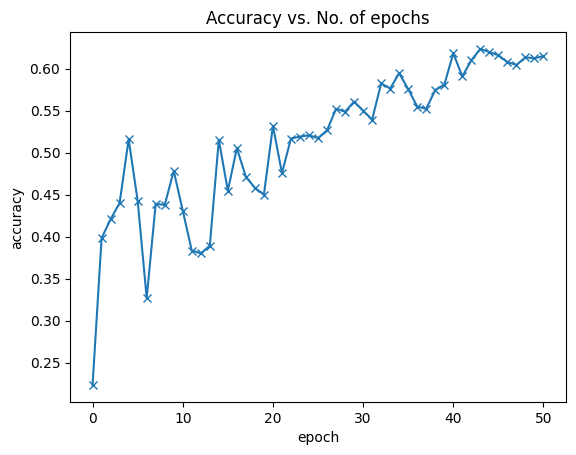

In [ ]:
plot_accuracies(history)

In [ ]:
# Đồ thị learning_rate (tốc độ học trong quá trình training)
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

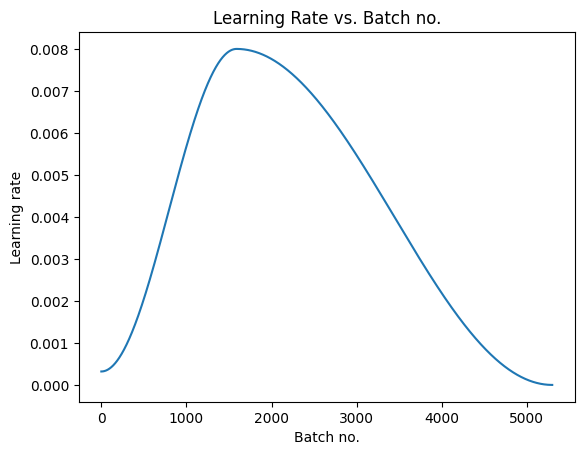

In [ ]:
plot_lrs(history)


In [ ]:
# Đồ thị loss (độ mất mát)
def plot_loss(history):
    loss = [x['val_loss'] for x in history]
    plt.plot(loss, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

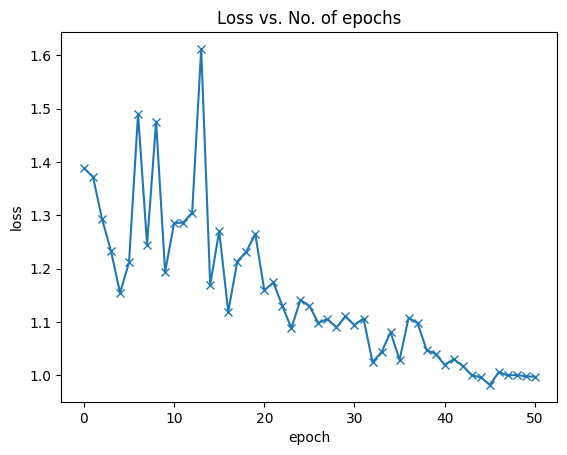

In [ ]:
plot_loss(history)

In [ ]:
# Tải mô hình đã lưu
model.load_state_dict(torch.load('best_model.pth', map_location=device))

# Chuyển mô hình về chế độ evaluation (đánh giá)
model.eval()

<ipython-input-31-efeed20825bf>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=device))


ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
# Tải thư viện cho việc in điểm đánh giá
from sklearn.metrics import precision_recall_fscore_support
test_dl = valid_dl

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dl:
        # Tải đầu vào và các nhãn vào thiết bị
        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tính toán các điểm Precision, Recall, và F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted'
)

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Precision: 0.593111149862987
Recall: 0.6127413127413127
F1-score: 0.5970591093962345
